In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import openpathsampling as paths
import numpy as np

from openpathsampling.analysis.tis_analysis import TISTransition
from openpathsampling.analysis.tis_analysis import sampleset_sample_generator

storage = paths.storage.Storage("_toy_retis.nc", mode="r")

In [2]:
%%time
storage.samples.cache_all()
storage.pathmovechanges.cache_all()

CPU times: user 459 ms, sys: 63.7 ms, total: 522 ms
Wall time: 504 ms


In [3]:
print len(storage.samplesets)

201


In [4]:
retis = storage.transitions.load(0)

In [5]:
%%time
retis.move_summary(storage)
print

pathreversal ran 20.6366630077% of the cycles with acceptance 100/188 (0.531914893617) 
shooting ran 40.834248079% of the cycles with acceptance 264/372 (0.709677419355) 
minus ran 1.317233809% of the cycles with acceptance 9/12 (0.75) 
repex ran 24.5883644347% of the cycles with acceptance 176/224 (0.785714285714) 

CPU times: user 87.8 ms, sys: 25.2 ms, total: 113 ms
Wall time: 95.4 ms


In [6]:
%%time
retis.move_summary(storage, 'shooting')
print

OneWayShootingMover I'face 5 ran 7.02524698134% of the cycles with acceptance 40/64 (0.625) 
OneWayShootingMover I'face 2 ran 9.65971459934% of the cycles with acceptance 72/88 (0.818181818182) 
OneWayShootingMover I'face 1 ran 5.268935236% of the cycles with acceptance 40/48 (0.833333333333) 
OneWayShootingMover I'face 4 ran 5.70801317234% of the cycles with acceptance 28/52 (0.538461538462) 
OneWayShootingMover I'face 3 ran 7.90340285401% of the cycles with acceptance 52/72 (0.722222222222) 
OneWayShootingMover I'face 0 ran 5.268935236% of the cycles with acceptance 32/48 (0.666666666667) 

CPU times: user 2.86 ms, sys: 1.29 ms, total: 4.15 ms
Wall time: 3.2 ms


In [7]:
def first_n(storage, n, trajid):
    sample_iter = sampleset_sample_generator(storage)
    first = []
    old=None
    for s in sample_iter:
        if s.replica == trajid:
            if s != old:
                first.append(s)
            old = s
        if len(first) == n:
            break
    return first

In [8]:
first40 = first_n(storage, 40, trajid=4)

In [9]:
%%time
from openpathsampling.visualize import PathTreeBuilder
from IPython.display import SVG

tree = PathTreeBuilder(storage)        
tree.rejected = True
tree.from_samples(first40)
view = tree.renderer
view.zoom = 0.8
view.scale_y = 24
view.scale_x = 14
view.font_size = 0.35

CPU times: user 1.96 s, sys: 322 ms, total: 2.28 s
Wall time: 2.31 s


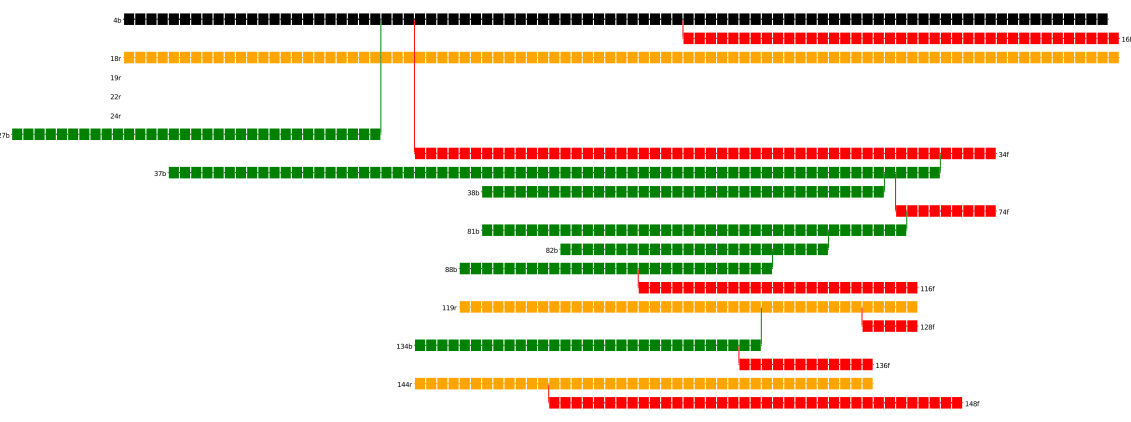

In [10]:
SVG(view.to_svg())

In [11]:
prev = first40[0].trajectory
decorrelated = [prev]
for s in first40:
    if not paths.Trajectory.is_correlated(s.trajectory, prev):
        decorrelated.append(s.trajectory)
        prev = s.trajectory
print "From these samples we have " + str(len(decorrelated)) + " decorrelated trajectories."

From these samples we have 4 decorrelated trajectories.


In [12]:
retis.ensemble_histogram_info['pathlength'].hist_args = { 'bin_width' : 5, 'bin_range' : (0, 150) }
retis.ensemble_histogram_info['max_lambda'].hist_args = { 'bin_width' : 0.02, 'bin_range' : (-0.35, 0.35) }

In [13]:
%%time
retis.all_statistics(storage=storage, weights=None, force=True)

CPU times: user 11.1 s, sys: 1.23 s, total: 12.3 s
Wall time: 12.4 s


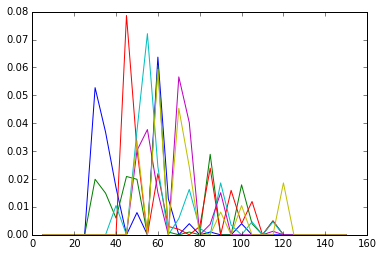

In [14]:
for ens in retis.ensembles:
    myhist = retis.histograms['pathlength'][ens]
    plt.plot(myhist.plot_bins(), myhist.normalized())

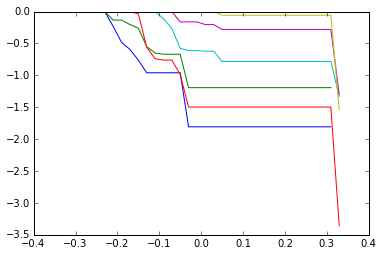

In [15]:
for ens in retis.ensembles:
    myhist = retis.histograms['max_lambda'][ens]
    plt.plot(myhist.plot_bins(), 
             np.log(myhist.reverse_cumulative())
            )

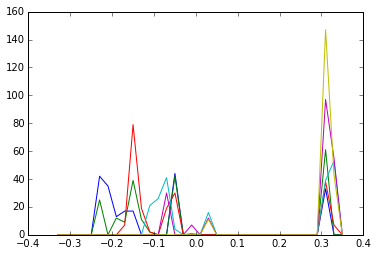

In [16]:
for ens in retis.ensembles:
    myhist = retis.histograms['max_lambda'][ens]
    plt.plot(myhist.plot_bins(), myhist())

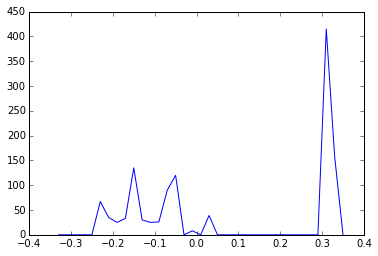

In [17]:
# TODO: add a histogram.sum_hist() function to add several histograms together
from operator import add
total_sampling = np.zeros(len(retis.histograms['max_lambda'][retis.ensembles[0]]()))
for ens in retis.ensembles:
    total_sampling = map(add, total_sampling, retis.histograms['max_lambda'][ens]())
plt.plot(myhist.plot_bins(), total_sampling);

In [18]:
from toy_plot_helpers import ToyPlot
plot = ToyPlot()
plot.add_pes(storage.engines.load(0).pes)

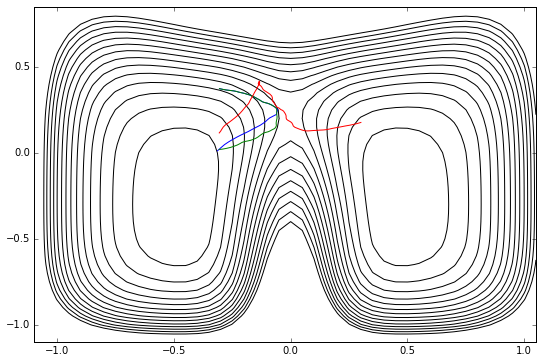

In [19]:
ens0_traj = [s.trajectory for s in storage.samples if s.ensemble == retis.ensembles[0]]
plt.contour(plot.X, plot.Y, plot._pes, levels=np.arange(0.0, 1.5, 0.1), colors='k')
for mytraj in ens0_traj[slice(None,None,15)]:
    plt.plot(mytraj.coordinates()[:,0,0], mytraj.coordinates()[:,0,1])

In [20]:
wham = retis.total_crossing_probability(method="wham")

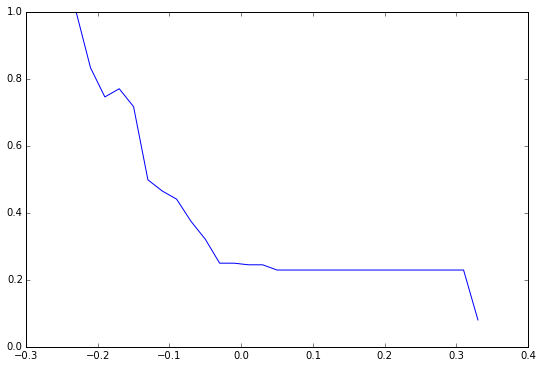

In [21]:
plt.plot(wham.keys(), wham.values());

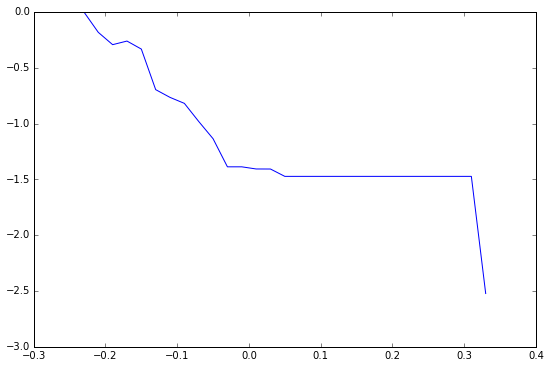

In [22]:
plt.plot(wham.keys(), np.log(wham.values()));

In [23]:
%%time
#retis.rate(storage=storage)
# TODO: conditional_transition_probability, minus_flux, rate
retis.conditional_transition_probability(storage, retis.ensembles[-1])

CPU times: user 133 ms, sys: 30.6 ms, total: 164 ms
Wall time: 143 ms


0.945273631840796

In [24]:
print retis._flux, retis.tcp(-0.05), retis.ctp[retis.ensembles[-1]]

None 0.32128231046 0.945273631841


In [25]:
#logging.getLogger("openpathsampling.ensemble").debug("test")
#flux_outside_ensemble = paths.AllOutXEnsemble(retis.minus_ensemble.innermost_vol)
#flux_inside_ensemble = paths.AllInXEnsemble(retis.minus_ensemble.innermost_vol)
minus = retis.movers['minus'][0]
for delta in storage.pathmovechanges:
    if minus in delta and delta.accepted:
        my_minus = delta
        break

delta = my_minus
#print flux_outside_ensemble.split(delta.samples[1].trajectory)
#print flux_inside_ensemble.split(delta.samples[1].trajectory)
